In [1]:
import numpy as np
import time

import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.layers import Dense, UpSampling2D, GlobalAveragePooling2D, Dropout, BatchNormalization

from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.merge import concatenate

from keras.models import load_model

from keras.optimizers import SGD, Adam, RMSprop

from keras.applications.vgg16 import preprocess_input

from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet201

from keras.utils.vis_utils import plot_model

from vgg16_places_365 import VGG16_Places365

Using TensorFlow backend.


In [2]:
train_data_dir = r'Splits/split1/train'
test_data_dir = r'Splits/split1/test'

nb_train_samples = 19850
nb_test_samples = 19850
epochs = 10
batch_size = 32
img_width=224
img_height=224
num_classes = 397

In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [4]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical')

Found 19850 images belonging to 397 classes.
Found 19850 images belonging to 397 classes.


In [5]:
vgg_places = VGG16_Places365(weights='places', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [6]:
vgg_imagenet = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

In [7]:
for layer in vgg_places.layers:
    layer.trainable = False

In [8]:
for layer in vgg_imagenet.layers:
    layer.trainable = False

In [9]:
vgg_places.summary()

Model: "vgg16-places365"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)   

In [10]:
vgg_imagenet.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
visible = Input(shape=(224,224,3))

model1 = vgg_places(visible)
model2 = vgg_imagenet(visible)

In [12]:
model1 = GlobalAveragePooling2D()(model1)
model2 = GlobalAveragePooling2D()(model2)

# model1 = Flatten(input_shape=vgg_places.output_shape[1:])(model1)
# model2 = Flatten(input_shape=vgg_imagenet.output_shape[1:])(model2)

In [13]:
merge = concatenate([model1,model2])

In [14]:
hidden1 = Dense(4096, activation='relu')(merge)
drop1 = Dropout(0.5)(hidden1)
hidden2 = Dense(4096, activation='relu')(drop1)
drop2 = Dropout(0.5)(hidden2)
hidden3 = Dense(4096, activation='relu')(drop2)
drop3 = Dropout(0.5)(hidden3)
output = Dense(num_classes, activation='softmax')(hidden2)
combined_model = Model(inputs=visible, outputs=output)

In [15]:
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16-places365 (Model)         (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg16-places365[1][0]            
____________________________________________________________________________________________

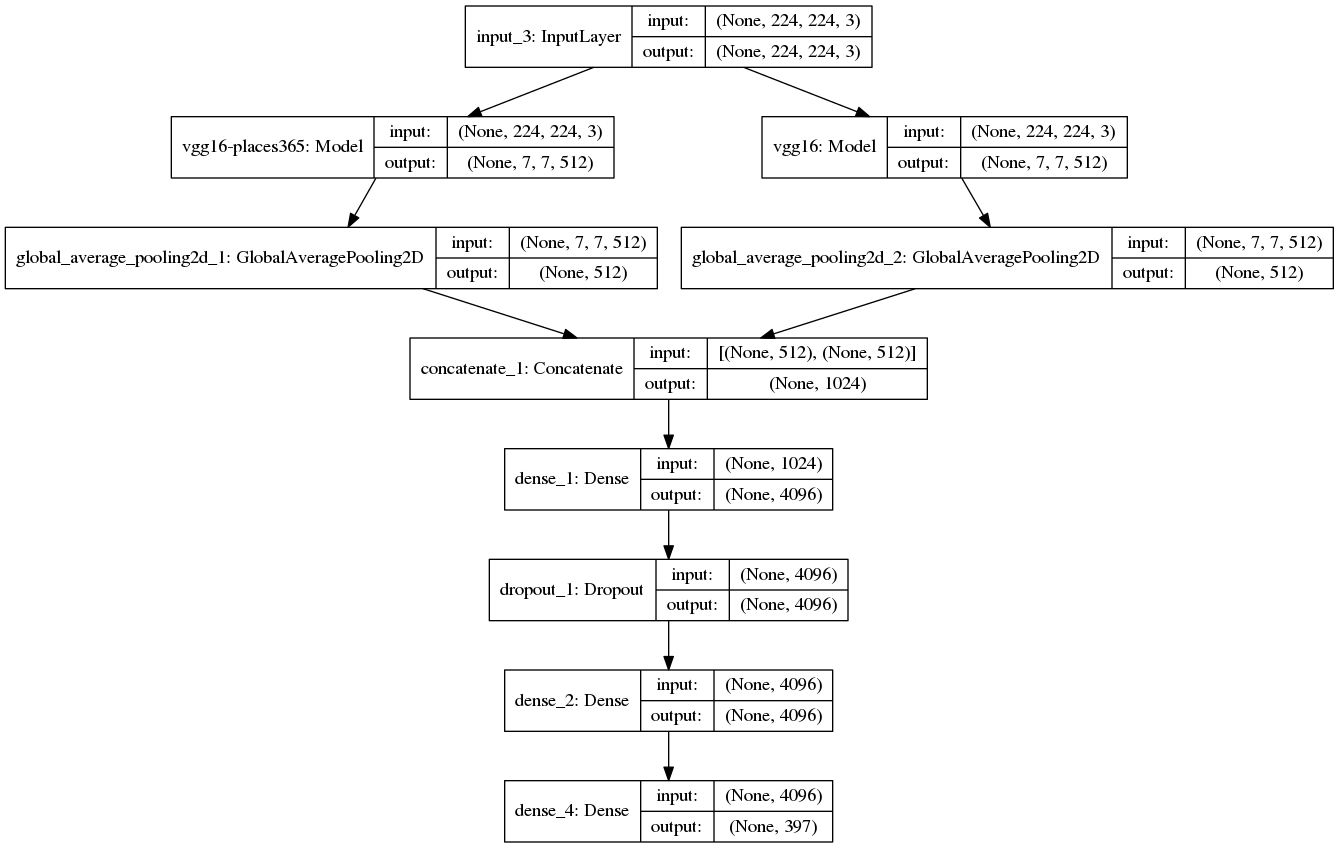

In [16]:
plot_model(combined_model, to_file='combined_model_plot.png', show_shapes=True, show_layer_names=True)

In [17]:
combined_model.compile(optimizer=RMSprop(lr=0.0002), loss='categorical_crossentropy', metrics=['accuracy'] )

In [18]:
import time

class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [19]:
from keras.callbacks import History , ModelCheckpoint

history = History()
checkpoint = ModelCheckpoint('Models/Run3/combined_vgg_best_model' , save_best_only=True)
time_callback = TimeHistory()

combined_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_train_samples // batch_size,
    callbacks = [history , checkpoint, time_callback],
    shuffle=True)


Epoch 1/10
 94/620 [===>..........................] - ETA: 9:07 - loss: 6.1911 - accuracy: 0.0984

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385478 bytes but only got 23143. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7276331008 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1879769088 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3014066176 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expe

619/620 [============================>.] - ETA: 1s - loss: 3.5143 - accuracy: 0.3270

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 150 bytes but only got 128. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


620/620 [==============================] - 1056s 2s/step - loss: 3.5126 - accuracy: 0.3272 - val_loss: 2.6147 - val_accuracy: 0.5109
Epoch 2/10
620/620 [==============================] - 1057s 2s/step - loss: 1.9845 - accuracy: 0.5550 - val_loss: 2.1145 - val_accuracy: 0.5480
Epoch 3/10
620/620 [==============================] - 1053s 2s/step - loss: 1.6294 - accuracy: 0.6312 - val_loss: 1.6595 - val_accuracy: 0.5572
Epoch 4/10
620/620 [==============================] - 1044s 2s/step - loss: 1.3986 - accuracy: 0.6845 - val_loss: 2.0965 - val_accuracy: 0.5777
Epoch 5/10
620/620 [==============================] - 1052s 2s/step - loss: 1.2469 - accuracy: 0.7226 - val_loss: 2.5394 - val_accuracy: 0.5884
Epoch 6/10
620/620 [==============================] - 1082s 2s/step - loss: 1.1386 - accuracy: 0.7472 - val_loss: 1.4585 - val_accuracy: 0.5846
Epoch 7/10
620/620 [==============================] - 1058s 2s/step - loss: 1.0330 - accuracy: 0.7776 - val_loss: 1.3692 - val_accuracy: 0.5854
Epo

In [20]:
combined_model.save('Models/Run3/combined_vgg_full_model')

In [21]:
model_history = np.array(history.history)
np.save('History/Run3/model_history', model_history)

In [22]:
model_time = np.array(time_callback.times)
np.save('History/Run3/model_time', model_time)

In [23]:
combined_model = load_model('Models/Run3/combined_vgg_best_model')

In [24]:
train_generator.reset()
validation_generator.reset()

In [25]:
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16-places365 (Model)         (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg16-places365[1][0]            
____________________________________________________________________________________________

In [26]:
for layer in combined_model.layers[1].layers[15:]:
    layer.trainable = True

In [27]:
for layer in combined_model.layers[2].layers[15:]:
    layer.trainable = True

In [28]:
combined_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
vgg16-places365 (Model)         (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
vgg16 (Model)                   (None, 7, 7, 512)    14714688    input_3[0][0]                    
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 512)          0           vgg16-places365[1][0]            
____________________________________________________________________________________________

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [29]:
combined_model.compile(optimizer=RMSprop(lr=0.00002), loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
from keras.callbacks import History , ModelCheckpoint

history = History()
checkpoint = ModelCheckpoint('Models/Run3/ft_combined_vgg_best_model' , save_best_only=True)
time_callback = TimeHistory()

combined_model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=5,
    validation_data=validation_generator,
    validation_steps=nb_train_samples // batch_size,
    callbacks = [history , checkpoint, time_callback],
    shuffle=True)

Epoch 1/5
 24/620 [>.............................] - ETA: 10:41 - loss: 0.8229 - accuracy: 0.8320

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1385478 bytes but only got 23143. Skipping tag 513
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 7276331008 bytes but only got 0. Skipping tag 7
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 1879769088 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 3014066176 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expe

619/620 [============================>.] - ETA: 1s - loss: 0.7143 - accuracy: 0.8585

/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 150 bytes but only got 128. Skipping tag 37510
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.5/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


620/620 [==============================] - 1053s 2s/step - loss: 0.7146 - accuracy: 0.8584 - val_loss: 1.8760 - val_accuracy: 0.6092
Epoch 2/5
620/620 [==============================] - 1047s 2s/step - loss: 0.5850 - accuracy: 0.8915 - val_loss: 2.4242 - val_accuracy: 0.6140
Epoch 3/5
620/620 [==============================] - 1056s 2s/step - loss: 0.5262 - accuracy: 0.9091 - val_loss: 2.4330 - val_accuracy: 0.6108
Epoch 4/5
620/620 [==============================] - 1079s 2s/step - loss: 0.4762 - accuracy: 0.9230 - val_loss: 3.2681 - val_accuracy: 0.6035
Epoch 5/5
620/620 [==============================] - 1064s 2s/step - loss: 0.4552 - accuracy: 0.9319 - val_loss: 1.9601 - val_accuracy: 0.6055


In [31]:
combined_model.save('Models/Run3/ft_combined_vgg_full_model')

In [32]:
model_history = np.array(history.history)
np.save('History/Run3/ft_model_history', model_history)

In [33]:
model_time = np.array(time_callback.times)
np.save('History/Run3/ft_model_time', model_time)